# <center> Sending and receiving a pulse demonstration

### <center> In this demo you will send and receive a pulse in loopback to demonstrate control over the QICK. 

By modifying the <code> config </code> Python dictionary in the below notebook cell, you can change several variables:
* The pulse length <code> length </code> in FPGA clock ticks (1 clock tick = 2.6 ns).
* The readout buffer length <code> readout_length </code> in FPGA clock ticks.
* The pulse envelope shape <code> pulse_style </code> (either <code> const </code> or <code> flat_top </code> or <code> arb </code>)
* The pulse amplitude <code> pulse_gain </code> in DAC units.
* The pulse frequency <code> pulse_freq </code> in MHz.
* The readout "time of flight" <code> adc_trig_offset </code> in FPGA clock ticks.
* The number of times you average the read <code> soft_avgs </code>

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import time
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
# Load bitstream with custom overlay
# soc = QickSoc()
# soc = QickSoc(bitfile="q3diamond.bit", force_init_clks=True)
soc = QickSoc(bitfile="qick_111_rfbv1_mux.bit")
# soc = QickSoc(bitfile="../../qick-amo/pynq/qick-amo.bit")

# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
# print(soccfg)


In [3]:
print(soccfg)


QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, switch ch 0, maxlen 65536
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, switch ch 1, maxlen 65536
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, switch ch 2, maxlen 65536
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, switch ch 3, maxlen 65536
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, switch ch 4, maxlen 65536
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, switch ch 5, maxlen 65536
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_sg_mux4_v2 - tProc output 7, switch ch -1, maxlen

  0%|          | 0/100 [00:00<?, ?it/s]

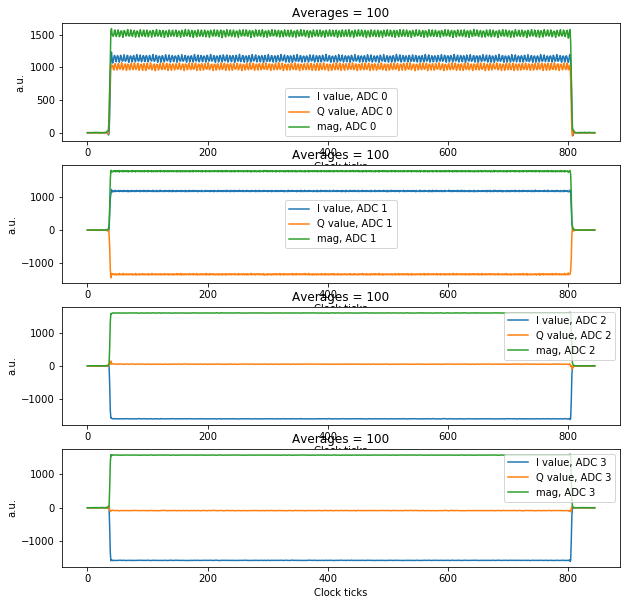

In [13]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        self.declare_gen(ch=cfg["res_ch"], nqz=cfg['nqz'],
                         mixer_freq=cfg["mixer_freq"],
                         mux_freqs=cfg["pulse_freqs"],
                         mux_gains=cfg["pulse_gains"],
                         ro_ch=cfg["ro_chs"][0])
        for iCh, ch in enumerate(cfg["ro_chs"]):  # configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, freq=cfg["pulse_freqs"][iCh],
                                 length=soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch),
                                 gen_ch=cfg["res_ch"])

        self.set_pulse_registers(ch=cfg["res_ch"], style="const",
                                 length=soccfg.us2cycles(cfg['length'], gen_ch=cfg['res_ch']),
                                 mask=[0, 1, 2, 3])
        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=soccfg.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

config = {
    'res_ch': 6,
    'ro_chs': [0,1,2,3],
    'nqz': 1,
    'mixer_freq': 1700,
    'pulse_freqs': [-200, 0, 200, 400],
    'pulse_gains': [1.0, 1.0, 1.0, 1.0],
    'pulse_style': 'const',
    'adc_trig_offset': 0.2,
    'length': 2,
    'readout_padding': 0.2,
    'relax_delay': 1,
    'reps': 1,
    'soft_avgs': 100
}
prog = LoopbackProgram(soccfg, config)
# print(prog)
# prog.acquire(soc, load_pulses=True, progress=True, debug=False)


prog = LoopbackProgram(soccfg, config)

iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# Plot results.
fig, axs = plt.subplots(4,1,figsize=(10,10))

for ii, iq in enumerate(iq_list):
    plot = axs[ii]
    plot.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plot.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("Clock ticks")
    plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend()

  0%|          | 0/96 [00:00<?, ?it/s]

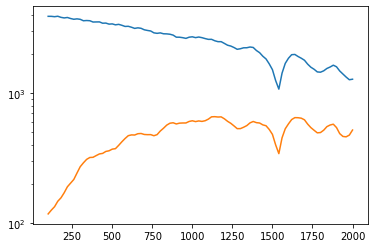

In [14]:
config['length'] = 100
config['pulse_freqs'] = [0, 0, 0, 0]
config['pulse_gains'] = [1.0, 0.0, 0.0, 0.0]
config['ro_chs'] = [0]
config['reps'] = 100

mixer_freqs = np.arange(100, 2001, 20)

mags = np.zeros((len(mixer_freqs),2))

for i, f in tqdm(list(enumerate(mixer_freqs))):
    config['mixer_freq'] = f
    
    for j in range(2):
        config['nqz'] = j+1
        prog = LoopbackProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
        res = np.array(res).T[0]
        mags[i,j] = np.abs(res[:,0]+1j*res[:,1])
plt.semilogy(mixer_freqs, mags[:,0])
plt.semilogy(mixer_freqs, mags[:,1])